In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13859817927818449490
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13803314870358782531
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8356062329888478225
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17348232064741188899
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os.path
import pickle
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Embedding
from keras.layers.merge import Concatenate

import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)


In [0]:
real.columns = ['tweet']

In [0]:
real['index'] = real.index

In [0]:
fake.columns = ['tweet']
fake['index'] = fake.index

In [0]:
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [0]:
real = real[cols]

In [0]:
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [0]:
real['label'] = 1
fake['label'] = 0
real.head()

,index,tweet,label
0,0,#Taiwan isn't a member of the #WHO. Taiwan tr...,1
1,1,From the DJs to the CJs.. Look whose in the PJ...,1
2,2,The @ClinicalBioinfo led by @xdopazo releases ...,1
3,3,IMF expects #Greece to be the worst hit econom...,1
4,4,More on #COVID19 - China witnessed a slight in...,1


In [0]:
fake.head()

,index,tweet,label
0,0,@chrislhayes I think it's important to note th...,0
1,1,"The problem is, it's the Chinese that are bein...",0
2,2,Do you know of any people who are looking for ...,0
3,3,Just as the COVID-19 pandemic has shown that t...,0
4,4,Covid-19's impact on the economy: The RBC Stat...,0


In [0]:
fake['tweet'][0]

"@chrislhayes I think it's important to note that there are two big areas that need to be addressed. First, the coronavirus and the existing system. Second, the existing system and health systems.  The first is very, very important, and that's a big concern. "

In [0]:
combined = pd.concat([fake, real])
features = combined['tweet']
labels = combined['label']
combined = combined.sample(frac = 1).reset_index(drop = True)
combined['index'] = combined.index
combined.tail()

,index,tweet,label
19992,19992,In an effort to protect the lives of our membe...,0
19993,19993,Corona came right when everybody was actually ...,1
19994,19994,How many of the people who die from #COVID19 c...,0
19995,19995,Coronavirus: Naloxone will come from a laborat...,0
19996,19996,“We are facing a new reality.” “We are facing ...,0


In [0]:
combined['tweet'] = combined['tweet'].astype(str).str.replace('[^a-zA-Z]',' ').str.lower()

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(combined['tweet'])
combined['tweet'] = tokenizer.texts_to_sequences(combined['tweet'])

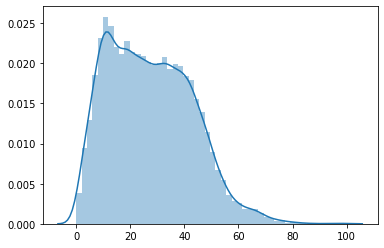

In [0]:
X_lens = [len(x) for x in combined['tweet'].values]
X_lens = np.array(X_lens)
sns.distplot(X_lens)

In [0]:
np.mean(X_lens)

27.258338750812623

In [0]:
np.std(X_lens)

15.516197470973962

In [0]:
MAX_LENGTH = 58
np.unique((X_lens >= MAX_LENGTH), return_counts=True)

(array([False,  True]), array([19377,   620]))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(combined, labels, test_size = 0.33, random_state = 42)

In [0]:
X_train_text = X_train.pop('tweet')
X_test_text = X_test.pop('tweet')

In [0]:
X_train_text = tf.keras.preprocessing.sequence.pad_sequences(X_train_text, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_text = tf.keras.preprocessing.sequence.pad_sequences(X_test_text, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [0]:
text_input = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='article_body_input')
text_embed = tf.keras.layers.Embedding(len(tokenizer.index_word) + 1, 50, input_length=MAX_LENGTH, name='article_body_embedding')(text_input)
text_conv = tf.keras.layers.Conv1D(256, 10, name='article_body_conv')(text_embed)
text_pool = tf.keras.layers.GlobalMaxPool1D(name='article_body_pooling')(text_conv)
# title_input = tf.keras.layers.Input(shape=(TITLE_LENGTH,), name = 'article_title_input')
# title_embed = tf.keras.layers.Embedding(title_tokenizer.index_word + 1, 50, input_length=TITLE_LENGTH, name='article_title_embedding')(title_input)
# title_conv = tf.keras.layers.Conv1D(256, 3, name='article_title_conv')(title_embed)
# title_pool = tf.keras.layers.GlobalMaxPooling1D(name='article_title_pooling')(title_conv)
vector_input = tf.keras.layers.Input(shape=(2,), name='twitter_input')
concat = tf.keras.layers.concatenate([text_pool, vector_input])
dense_100 = tf.keras.layers.Dense(100, activation='relu')(concat)
dense_50 = tf.keras.layers.Dense(50, activation='relu')(dense_100)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_50)
model = tf.keras.models.Model(inputs=[text_input, vector_input], outputs=out_layer)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
article_body_input (InputLayer) [(None, 58)]         0                                            
__________________________________________________________________________________________________
article_body_embedding (Embeddi (None, 58, 50)       1782050     article_body_input[0][0]         
__________________________________________________________________________________________________
article_body_conv (Conv1D)      (None, 49, 256)      128256      article_body_embedding[0][0]     
__________________________________________________________________________________________________
article_body_pooling (GlobalMax (None, 256)          0           article_body_conv[0][0]          
______________________________________________________________________________________________

In [0]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
history = model.fit([X_train_text, X_train], y_train, epochs=100, batch_size=128, validation_data=([X_test_text, X_test], y_test), callbacks=[callback])

Epoch 1/100
105/105 [==============================] - 4s 35ms/step - loss: 64.7541 - accuracy: 0.5267 - val_loss: 1.8723 - val_accuracy: 0.6091
Epoch 2/100
105/105 [==============================] - 3s 29ms/step - loss: 0.5407 - accuracy: 0.8521 - val_loss: 0.0750 - val_accuracy: 0.9733
Epoch 3/100
105/105 [==============================] - 3s 30ms/step - loss: 0.0639 - accuracy: 0.9776 - val_loss: 0.0727 - val_accuracy: 0.9694
Epoch 4/100
105/105 [==============================] - 3s 30ms/step - loss: 0.0529 - accuracy: 0.9811 - val_loss: 0.0547 - val_accuracy: 0.9805
Epoch 5/100
105/105 [==============================] - 3s 30ms/step - loss: 0.0423 - accuracy: 0.9853 - val_loss: 0.0559 - val_accuracy: 0.9785
Epoch 6/100
105/105 [==============================] - 3s 30ms/step - loss: 0.0260 - accuracy: 0.9949 - val_loss: 0.0477 - val_accuracy: 0.9823
Epoch 7/100
105/105 [==============================] - 3s 30ms/step - loss: 0.0191 - accuracy: 0.9965 - val_loss: 0.0572 - val_accuracy

In [0]:
preds = model.predict([X_test_text, X_test])

In [0]:
model.evaluate([X_test_text, X_test], y_test)

207/207 [==============================] - 1s 4ms/step - loss: 0.0477 - accuracy: 0.9823


[0.047691937536001205, 0.982272744178772]

In [0]:
precision_score(y_test.values, preds.reshape(-1).astype('int64'))

1.0

In [0]:
recall_score(y_test.values, preds.reshape(-1).astype('int64'))

0.3304904051172708

In [0]:
f1_score(y_test.values, preds.reshape(-1).astype('int64'))

0.4967948717948718

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


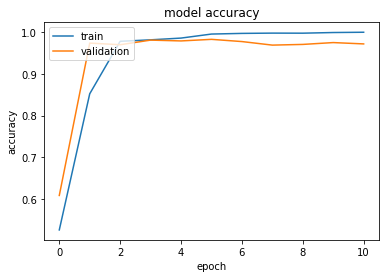

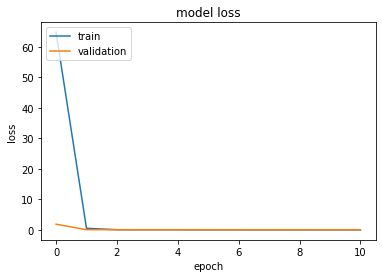

In [0]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()